In [1]:
import wrds
db=wrds.Connection(wrds_username='hlanfran')
import numpy as np
import pandas as pd

Loading library list...
Done


In [34]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1900-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc, a.hsiccd 
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 


In [3]:

#variables
msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1
msf.sort_values(['permno','date'])

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']

In [4]:
print('duplicates in data on returns?')
print(data.duplicated(subset=['date','permno']).sum(),'\n')

print(' How many obervations do we have in a month?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

print('\n Let us limit our attention to stocks we observe often enough...')


duplicates in data on returns?
0 

 How many obervations do we have in a month?
max: 2462
min: 1370

 How often do we observe a given stock?
max: 384
min: 1

 Let us limit our attention to stocks we observe often enough...


In [5]:
#Keep interesting data
data=data[data.obs==384]

In [6]:
#Get 1995 year
data_filter = data[(data['date'] > '1995-01-01') & (data['date'] < '1995-12-30')]

In [7]:
#Sort unique stocks
data_unique = data_filter.drop_duplicates(subset=['permno'])

In [8]:
data_unique["market-capitalization"] = data_unique["shrout"] * data_unique["prc"]

C:\Users\hugol\AppData\Local\Temp\ipykernel_2232\4005763058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique["market-capitalization"] = data_unique["shrout"] * data_unique["prc"]


In [9]:
#get largest stocks
data_unique = data_unique.nlargest(100,"market-capitalization")

In [10]:
#filter data to keep only largest stocks
data = data[data["permno"].isin(data_unique["permno"].values)]

In [13]:
#assign industry
data["industry"] = data["hsiccd"].map(lambda x: get_industry(x))

In [63]:
industry_portofolios = pd.read_csv("12_Industry_Portfolios.CSV")

In [64]:
industry_portofolios["Date"] = industry_portofolios["Date"].map(lambda x: str(x)[0:4] + "-" + str(x)[4:])

In [65]:
industry_portofolios = industry_portofolios[(industry_portofolios['Date'] >= '1990-01') & (industry_portofolios['Date'] <= '2021-12')]

In [66]:
industry_portofolios

,Date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
762,1990-01,-9.43,-3.84,-5.61,-4.30,-8.05,-1.25,-13.39,-5.35,-6.43,-7.36,-9.78,-7.32
763,1990-02,-0.39,5.13,2.71,3.10,2.18,4.02,-0.35,0.21,1.99,-2.06,2.32,2.95
764,1990-03,4.54,2.90,4.60,-0.57,2.22,4.47,4.18,-0.75,5.11,3.85,-1.56,1.92
765,1990-04,-0.27,-4.04,-2.96,-3.54,-2.16,-2.02,-3.46,-5.51,-2.10,0.29,-4.23,-2.21
766,1990-05,9.04,7.76,7.75,6.03,8.93,12.56,9.38,5.43,11.65,12.77,9.26,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2021-08,-0.29,1.73,0.68,-1.35,0.20,4.68,1.40,3.23,2.39,2.85,2.66,2.30
1142,2021-09,-4.57,2.84,-6.24,10.63,-4.69,-6.27,-5.65,-4.84,-4.20,-5.94,-1.59,-3.50
1143,2021-10,3.75,30.63,4.51,10.25,5.94,7.69,-4.30,5.11,4.96,2.32,6.87,7.32
1144,2021-11,-3.77,1.70,-1.09,-5.46,0.43,0.99,-7.24,-1.96,1.50,-4.18,-5.67,-3.97


In [18]:
data

,permno,date,ret,shrout,prc,hsiccd,size,const,size_lag,obs,vwretd,rf,mprem,exret,industry
6737,10516,1990-01-31,-0.134054,281065.0,20.000000,2046.0,5.621300e+06,1,NaN,384,-0.070114,0.006390,-0.076503,-0.140444,Consumer Nondurables
6738,10516,1990-02-28,0.050000,281065.0,21.000000,2046.0,5.902365e+06,1,5.621300e+06,384,0.014900,0.006441,0.008459,0.043559,Consumer Nondurables
6739,10516,1990-03-30,0.083333,283801.0,22.750000,2046.0,6.456473e+06,1,5.902365e+06,384,0.024148,0.006688,0.017460,0.076645,Consumer Nondurables
6740,10516,1990-04-30,0.034066,283801.0,23.500000,2046.0,6.669324e+06,1,6.456473e+06,384,-0.028283,0.006283,-0.034567,0.027782,Consumer Nondurables
6741,10516,1990-05-31,0.127660,283801.0,26.500000,2046.0,7.520726e+06,1,6.669324e+06,384,0.088935,0.006132,0.082803,0.121528,Consumer Nondurables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400971,70519,2001-09-28,-0.115721,5214461.0,40.500000,6021.0,2.111857e+08,1,2.388223e+08,384,-0.091497,0.001983,-0.093480,-0.117704,Finance
400972,70519,2001-10-31,0.123951,5214461.0,45.520000,6021.0,2.373623e+08,1,2.111857e+08,384,0.027847,0.001746,0.026101,0.122205,Finance
400973,70519,2001-11-30,0.055800,5144814.0,47.900002,6021.0,2.464366e+08,1,2.373623e+08,384,0.078789,0.001441,0.077348,0.054359,Finance
400974,70519,2001-12-31,0.053862,5144814.0,50.480000,6021.0,2.597102e+08,1,2.464366e+08,384,0.017854,0.001364,0.016489,0.052498,Finance


# A) Value Weighted Momentum Strategy

In [144]:
data["Momentum"] = np.zeros(38400)

In [218]:
for stock in data["permno"].unique():
    data["Momentum"][data["permno"] == stock] = data[data["permno"] == stock]["vwretd"].rolling(11,11).sum()
    #shift by 1 (we calculate t-11 to t so we need to shift it by 1 )
    for i in range(len(data[data["permno"] == stock]) - 1):
        if(i>=11):
            data["Momentum"][data["permno"] == stock].iloc[i] = data["Momentum"][data["permno"] == stock].iloc[i+1]

In [219]:
# keep only dates after 1 year
dates = data["date"].unique()[11:]

In [220]:
momentum = pd.DataFrame({"date":dates,"Momentum_large":0,"Momentum_small":0,"Market_cap_large":0,"Market_cap_small":0,"Market_cap_total":0,"Momentum_strategy":0})

In [221]:
for date in momentum.date:
    #10 largest and smallet stocks returns in window 
    largest = data[data["date"] == date].nlargest(10,"Momentum")
    smallest = data[data["date"] == date].nsmallest(10,"Momentum")
    
    #append returns
    momentum["Momentum_large"][momentum["date"] == date] = np.mean(largest["Momentum"])
    momentum["Momentum_small"][momentum["date"] == date] = np.mean(smallest["Momentum"])
    
    #add market cap of largest and smallet stocks
    momentum["Market_cap_large"][momentum["date"] == date] = np.sum(largest["prc"]*largest["shrout"])
    momentum["Market_cap_small"][momentum["date"] == date] = np.sum(smallest["prc"]*smallest["shrout"])
    
    #add total market cap
    momentum["Market_cap_total"][momentum["date"] == date] = np.sum(data[data["date"] == date]["prc"]*data[data["date"] == date]["shrout"])

In [222]:
#Sell small return stocks for larger profit stocks 
# returns_market_cap_large * (market_cap_small + market_cap_large)/total_market_cap - returns_market_cap_small * (market_cap_small)/total_market_cap  is the new return for the strategy implying we sell 
# market_cap_small to invest into market_cap_large

momentum["Momentum_strategy"] = momentum["Momentum_large"] * (momentum["Market_cap_large"]+momentum["Market_cap_small"])/momentum["Market_cap_total"] - momentum["Momentum_small"] * (momentum["Market_cap_small"])/momentum["Market_cap_total"] 

In [223]:
returns = momentum["Momentum_strategy"]
cum_returns = (1 + momentum["Momentum_strategy"]).cumprod()
mean = np.mean(momentum["Momentum_strategy"])
std = np.std(momentum["Momentum_strategy"])
SR = ((mean - np.mean(data["rf"]))/std)
print(f"The mean is {mean}, the std is {std} and the sharpe ratio is {SR}")

The mean is 0.02252127030365388, the std is 0.032027574155766424 and the sharpe ratio is 0.6390966853293171


<AxesSubplot:>

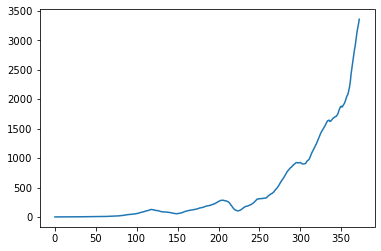

In [224]:
cum_returns.plot()

In [225]:
cum_returns

0         1.007109
1         1.022481
2         1.056367
3         1.108356
4         1.134457
          ...     
368    3014.762764
369    3119.822131
370    3205.884450
371    3277.203541
372    3360.519760
Name: Momentum_strategy, Length: 373, dtype: float64

# B

In [117]:
data_regression = data[(data['date'] > '1991-01-01')]

In [118]:
from sklearn.linear_model import LinearRegression

#regress on market premium
mprem = data_regression.groupby("date").sum()["mprem"]
lm = LinearRegression().fit(mprem.to_numpy().reshape(-1, 1),returns.to_numpy().reshape(-1, 1))

print(f"The alpha for the market premium is {lm.intercept_.item()} and the beta is {lm.coef_.item()}")

The alpha for the market premium is 0.07503864117395172 and the beta is 0.007844779943200101


In [119]:
industry_portofolios_momentum = industry_portofolios[(industry_portofolios['Date'] >= '1991-01')]

alphas = []
betas = []
#regress on industry
for industry in industry_portofolios.columns[1:]:
    l = LinearRegression().fit(industry_portofolios_momentum[industry].to_numpy().reshape(-1, 1)/100,returns.to_numpy().reshape(-1, 1))
    betas.append(l.coef_.item())
    alphas.append(l.intercept_.item()) 

In [120]:
#remove Date
#X = industry_portofolios_momentum.loc[:, industry_portofolios_momentum.columns!='Date']
#l = LinearRegression().fit(X.to_numpy()/100,returns.to_numpy().reshape(-1, 1))

In [121]:
alphas

[0.07533943429446975,
 0.07733423822479221,
 0.07491661541928549,
 0.07708153381784989,
 0.0756273450532433,
 0.07556496567432235,
 0.0771300954578182,
 0.07716882440035859,
 0.07482524224588573,
 0.07494511997571243,
 0.0750351598821185,
 0.07595809069586168]

In [122]:
import statsmodels.api as sm

est = sm.OLS(returns.to_numpy().reshape(-1, 1),X.to_numpy()/100)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.156
Model:                            OLS   Adj. R-squared (uncentered):              0.128
Method:                 Least Squares   F-statistic:                              5.558
Date:                Mon, 02 May 2022   Prob (F-statistic):                    9.62e-09
Time:                        08:41:43   Log-Likelihood:                          229.24
No. Observations:                 372   AIC:                                     -434.5
Df Residuals:                     360   BIC:                                     -387.4
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Interpretation

We observe that with respect to a significance treshold of 5%, the significant coefficients are the 6th and 8th one, respectively the one for BusEq	and Utils industries We have a not that great R2 and the alphas are not particularly high so we can conclude they are responsible for the strategy performance

### Helpers

In [12]:
def get_industry(number):

    if(((number>=100) and (number<=999)) or (number>=2000 and number<=2399) or  (number>=2700 and number<=2749) or  (number>=2770 and number<=2799) or  (number>=3100 and number<=3199)  or  (number>=3940 and number<=3989)):
        return  "Consumer Nondurables"

    if((number>=2500 and number<=2519) or (number>=2590 and number<=2599) or (number>=3630 and number<=3659) or (number>=3710 and number<=3711) or (number>=3714 and number<=3714) or (number>=3716 and number<=3716) or (number>=3750 and number<=3751) or (number>=3792 and number<=3792) or (number>=3900 and number<=3939) or  (number>=3900 and number<=3939)):
        return "Consumer Durables"
    
    if((number>=2520 and number<=2589) or  (number>=2600 and number<=2699) or  (number>=2750 and number<=2769) or  (number>=3000 and number<=3099) or (number>=3200 and number<=3569) or (number>=3580 and number<=3629) or (number>=3700 and number<=3709) or(number>=3712 and number<=3713) or(number>=3715 and number<=3715) or(number>=3717 and number<=3749) or(number>=3752 and number<=3791) or(number>=3793 and number<=3799) or(number>=3830 and number<=3839) or(number>=3860 and number<=3899)):
        return "Manufacturing"
    
    if((number>=1200 and number<=1399) or  (number>=2900 and number<=2999)):
        return "Oil, Gas, and Coal Extraction and Products"
    
    if((number>=2800 and number<=2829) or  (number>=2840 and number<=2899)):
        return "Chemicals and Allied Products"
    
    if((number>=3570 and number<=3579) or  (number>=3660 and number<=3692) or (number>=3694 and number<=3699) or  (number>=3810 and number<=3829) or  (number>=7370 and number<=7379)):
        return "Business Equipment -- Computers, Software, and Electronic Equipment"
    
    if((number>=4800 and number<=4899)):
        return "Telephone and Television Transmission"
    
    if((number>=4900 and number<=4949)):
        return "Utilities"
    
    if((number>=5000 and number<=5999) or  (number>=7200 and number<=7299) or (number>=7600 and number<=7699)):
        return "Wholesale, Retail, and Some Services (Laundries, Repair Shops)"
    
    if((number>=2830 and number<=2839) or  (number>=3693 and number<=3693) or (number>=3840 and number<=3859)  or (number>=8000 and number<=8099)):
        return "Healthcare, Medical Equipment, and Drugs"
    
    if((number>=6000 and number<=6999)):
        return "Finance"
    
    else:
        return "Other -- Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment"